In [1]:
import ensaio
import pandas as pd

fname = ensaio.fetch_southern_africa_gravity(version=1)
data = pd.read_csv(fname)
data

,longitude,latitude,height_sea_level_m,gravity_mgal
0,18.34444,-34.12971,32.2,979656.12
1,18.36028,-34.08833,592.5,979508.21
2,18.37418,-34.19583,18.4,979666.46
3,18.40388,-34.23972,25.0,979671.03
4,18.41112,-34.16444,228.7,979616.11
...,...,...,...,...
14354,21.22500,-17.95833,1053.1,978182.09
14355,21.27500,-17.98333,1033.3,978183.09
14356,21.70833,-17.99166,1041.8,978182.69
14357,21.85000,-17.95833,1033.3,978193.18


In [2]:
import boule as bl

normal_gravity = bl.WGS84.normal_gravity(data.latitude, data.height_sea_level_m)
disturbance = data.gravity_mgal - normal_gravity

In [3]:
import pyproj

projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.height_sea_level_m)

In [4]:
import harmonica as hm

eqs = hm.EquivalentSourcesGB(
    depth=9e3, damping=10, block_size=2e3, window_size=100e3, random_state=42
)

In [5]:
eqs.estimate_required_memory(coordinates)

np.int64(1210568)

In [6]:
eqs.fit(coordinates, disturbance)

EquivalentSourcesGB(block_size=2000.0, damping=10, depth=9000.0,
                    random_state=42, window_size=100000.0)

In [7]:
import verde as vd
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=2.5e3,
)
grid = eqs.grid(grid_coords, data_names=["gravity_disturbance"])
grid

<xarray.Dataset> Size: 3MB
Dimensions:              (northing: 389, easting: 412)
Coordinates:
  * easting              (easting) float64 3kB 1.174e+06 1.179e+06 ... 3.228e+06
  * northing             (northing) float64 3kB -3.665e+06 ... -1.724e+06
    upward               (northing, easting) float64 1MB 2.5e+03 ... 2.5e+03
Data variables:
    gravity_disturbance  (northing, easting) float64 1MB 5.88 5.895 ... 4.188
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=2000.0, damping=10...

In [8]:
grid_masked = vd.distance_mask(coordinates, maxdist=50e3, grid=grid)

In [9]:
 import pygmt

 # Needed so that displaying works on jupyter-sphinx and sphinx-gallery at
 # the same time. Using PYGMT_USE_EXTERNAL_DISPLAY="false" in the Makefile
 # for sphinx-gallery to work means that fig.show won't display anything here
 # either.
 pygmt.set_display(method="notebook")

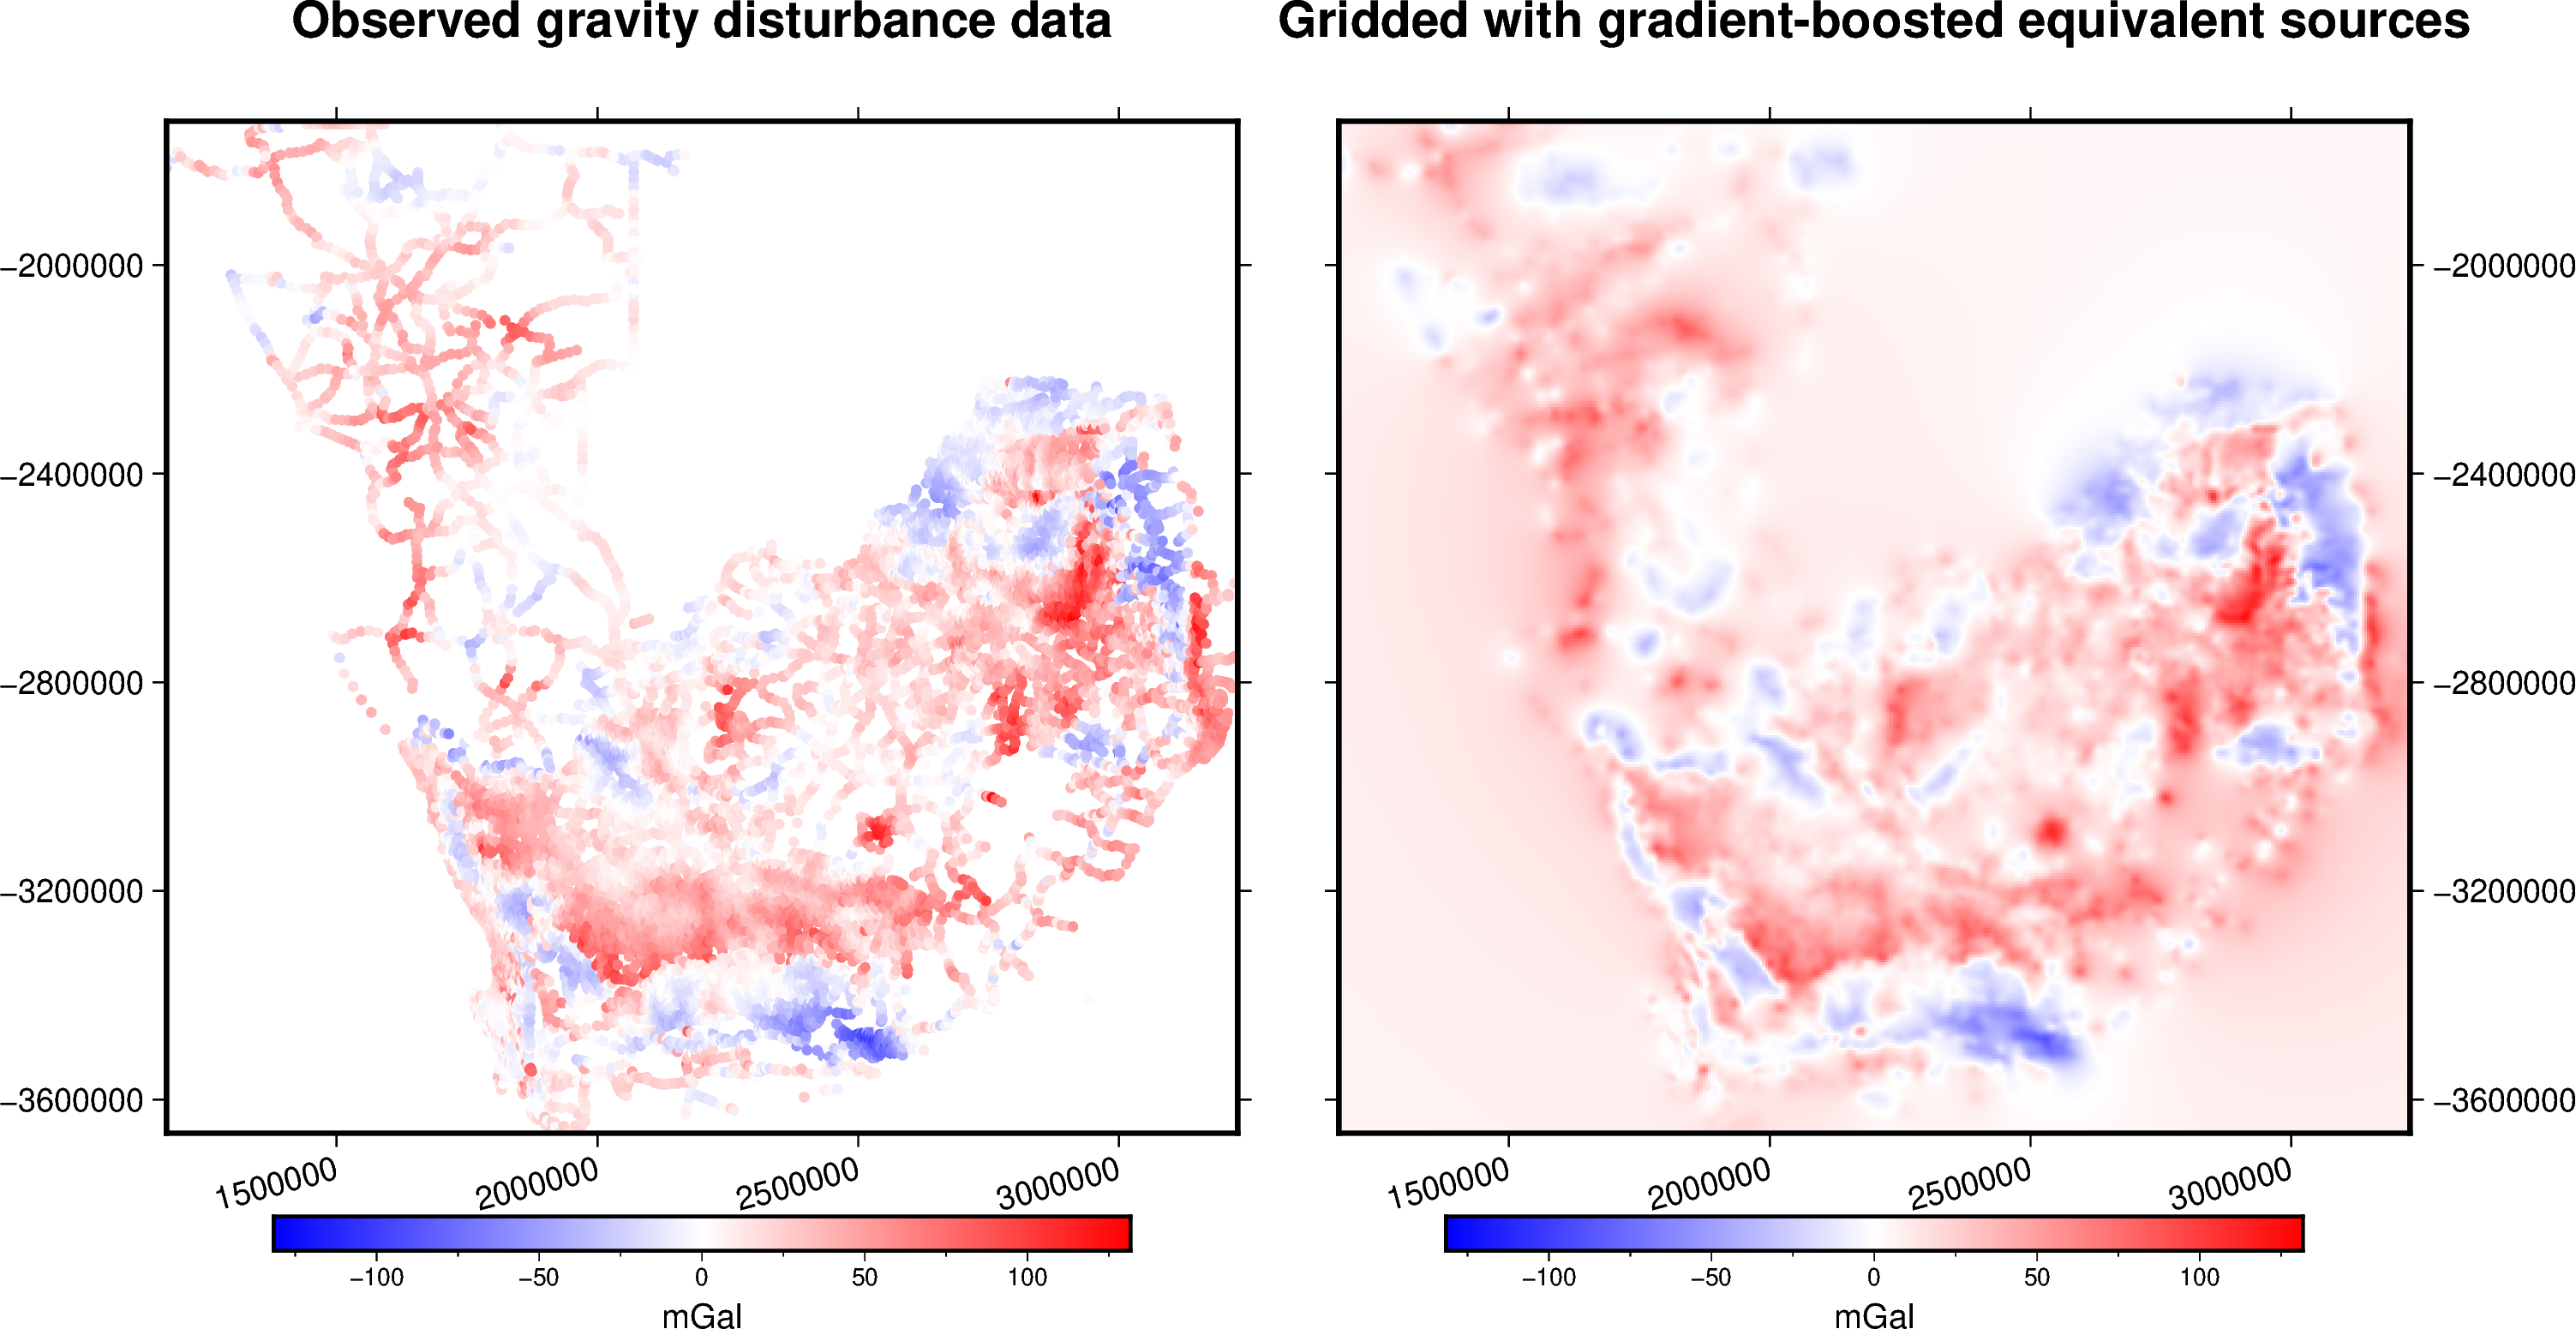

In [10]:
import pygmt

# Set figure properties
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"

maxabs = vd.maxabs(disturbance, grid_masked.gravity_disturbance)

fig = pygmt.Figure()

# Make colormap of data
pygmt.makecpt(cmap="polar+h0",series=(-maxabs, maxabs,))

title = "Observed gravity disturbance data"
with pygmt.config(FONT_TITLE="14p"):
    fig.plot(
        projection=fig_proj,
        region=region,
        frame=[f"WSne+t{title}", "xa500000+a15", "ya400000"],
        x=easting,
        y=northing,
        fill=disturbance,
        style="c0.1c",
        cmap=True,
    )
fig.colorbar(cmap=True, frame=["a50f25", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

title = "Gridded with gradient-boosted equivalent sources"
with pygmt.config(FONT_TITLE="14p"):
    fig.grdimage(
        frame=[f"ESnw+t{title}", "xa500000+a15", "ya400000"],
        grid=grid.gravity_disturbance,
        cmap=True,
    )

fig.colorbar(cmap=True, frame=["a50f25", "x+lmGal"])

fig.show()